In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch 
from botorch.utils.sampling import draw_sobol_samples

In [2]:
design_space_bounds = np.asarray([(0.0, 35.0), (0.0, 35.0)])
ITERATION = 15
N_SAMPLES = 48
bounds = torch.tensor(design_space_bounds).transpose(-1, -2)

In [3]:
# samples = draw_sobol_samples(bounds=bounds, n=N_SAMPLES, q=1).view(N_SAMPLES, len(design_space_bounds))
# smaples = samples.numpy()
samples = np.load("./random_eval_samples.npy")

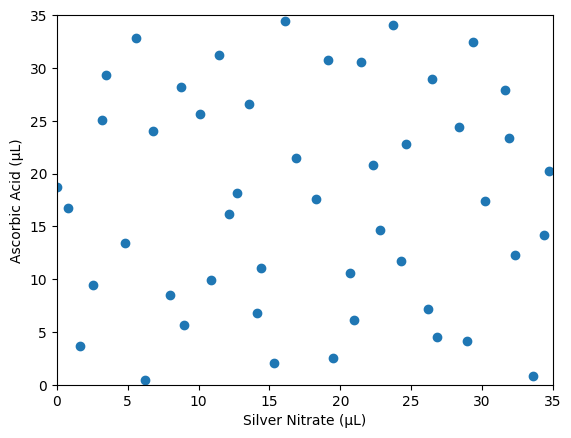

In [4]:
fig, ax = plt.subplots()
ax.scatter(samples[:,0], samples[:,1])
ax.set_xlim([bounds[0,0], bounds[1,0]])
ax.set_ylim([bounds[0,1], bounds[1,1]])
ax.set_xlabel("Silver Nitrate (µL)")
ax.set_ylabel("Ascorbic Acid (µL)")
plt.show()

### Read Sphere retrosynthesis

In [5]:
traj = torch.load("../paper/retrosynthesis/sphere/optim_traj.pkl", map_location=torch.device('cpu'))
trajectory = traj["X_traj"][1,...]
sphere_optim = trajectory[-1,:]
print("Sphere retrosynthesis composition : ", sphere_optim)

Sphere retrosynthesis composition :  tensor([ 0.3572, 34.5002], dtype=torch.float64)


### Read nanorod retrosynthesis

In [6]:
traj = torch.load("../paper/retrosynthesis/nanorod/optim_traj.pkl", map_location=torch.device('cpu'))
trajectory = traj["X_traj"][2,...]
nanorod_optim = trajectory[-1,:]
print("Nanorod retrosynthesis composition : ", nanorod_optim)

Nanorod retrosynthesis composition :  tensor([19.5415, 22.9251], dtype=torch.float64)


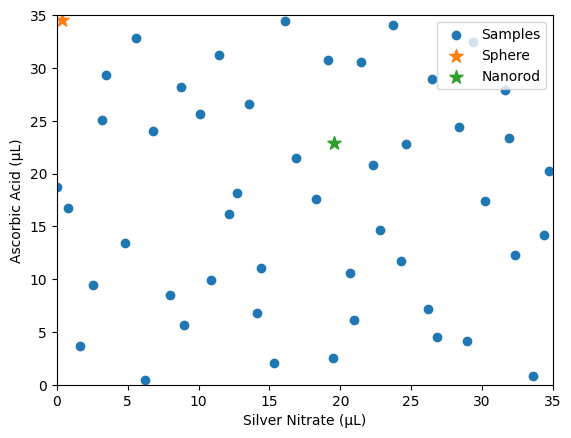

In [7]:
fig, ax = plt.subplots()
ax.scatter(samples[:,0], samples[:,1], label="Samples")
ax.scatter(sphere_optim[0], sphere_optim[1], label="Sphere", marker="*", s=100)
ax.scatter(nanorod_optim[0], nanorod_optim[1], label = "Nanorod", marker="*", s=100)
ax.set_xlim([bounds[0,0], bounds[1,0]])
ax.set_ylim([bounds[0,1], bounds[1,1]])
ax.set_xlabel("Silver Nitrate (µL)")
ax.set_ylabel("Ascorbic Acid (µL)")
ax.legend()
plt.show()

### Prepare composition file for Opentrons

In [8]:
comps = np.vstack((sphere_optim, nanorod_optim, samples))
comps.shape

(50, 2)

## Plot UV-Vis

In [9]:
import sys 
sys.path.append("/Users/pozzolabadmin/Documents/codebase/experiments/peptide_phase_mapping")
from utils import plot_phasemap
import pandas as pd 

In [10]:
uvvis_data = pd.read_excel("../uvvis/itr_15.xlsx", engine='openpyxl')
water_uvvis = pd.read_excel("../uvvis/water.xlsx", engine='openpyxl')
water = water_uvvis.iloc[:,-1].to_numpy()
wavelength = uvvis_data["Wavelength"].to_numpy()
well_names = uvvis_data.columns[1:].to_numpy()
print(well_names)

['A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'A10' 'A11' 'A12' 'B1' 'B2'
 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B9' 'B10' 'B11' 'B12' 'C1' 'C2' 'C3' 'C4'
 'C5' 'C6' 'C7' 'C8' 'C9' 'C10' 'C11' 'C12' 'D1' 'D2' 'D3' 'D4' 'D5' 'D6'
 'D7' 'D8' 'D9' 'D10' 'D11' 'D12' 'E1' 'E2']


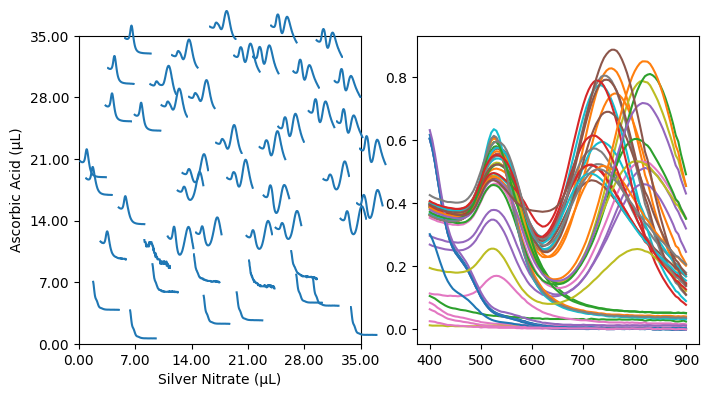

In [15]:
spectra = []
for well_name in well_names[2:]:
    y = uvvis_data[well_name].values-water
    spectra.append(y)

spectra = np.asarray(spectra)
fig, axs = plt.subplots(1,2, figsize=(2*4,4))
plot_phasemap(bounds, axs[0], samples, spectra)
axs[0].set_xlabel("Silver Nitrate (µL)")
axs[0].set_ylabel("Ascorbic Acid (µL)")

for si in spectra:
    axs[1].plot(wavelength, si)
plt.show()

In [18]:
np.save("./spectra_evals.npy", spectra)

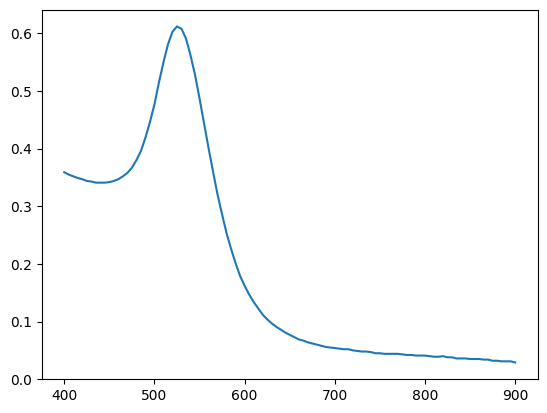

In [12]:
sphere_retrosynth_expt = uvvis_data["A1"].values-water
plt.plot(wavelength, sphere_retrosynth_expt)
plt.show()

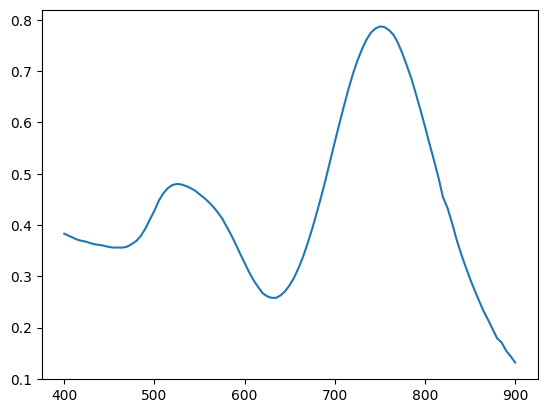

In [13]:
nanorod_retrosynth_expt = uvvis_data["A2"].values-water
plt.plot(wavelength, nanorod_retrosynth_expt)
plt.show()

In [14]:
np.savez("sphere_retrosynth_expt.npz", wl=wavelength, I=sphere_retrosynth_expt)
np.savez("nanorod_retrosynth_expt.npz", wl=wavelength, I=nanorod_retrosynth_expt)